In [6]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("/projects/renal/srm_detection_main"))


from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import monai
from monai.data import pad_list_data_collate

from utils import *
from constants import *
from data.transforms import get_kidney_transforms, get_srm_transforms, InfiniteSampler
from data.dataset import ROIDataset
from monai.data import pad_list_data_collate

from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    ScaleIntensityRanged,
    Spacingd,
    ResampleToMatchd,
    LabelToContourd,
    KeepLargestConnectedComponentd,
    FillHolesd,
    RandSpatialCropSamplesd,
    MapLabelValued,
)


2024-09-20 16:20:43.038532: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 16:20:43.042583: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 16:20:43.110192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper functions

In [7]:
def get_kidney_transforms(mode="holdout", keys=("img",)):  # Only "img" key since you're using images
    """Get specific transforms for labeled and unlabeled datasets"""
    xforms = [
        LoadImaged(keys, allow_missing_keys=True),
        EnsureChannelFirstd(keys),
        Spacingd(keys[0], pixdim=(2.0, 2.0, 5.0), mode="bilinear"),  # Only apply to "img"
        ScaleIntensityRanged(keys[0], a_min=-500.0, a_max=500.0, b_min=0.0, b_max=1.0, clip=True),
    ]
    
    # Additional transforms for other modes
    if mode == "unlabeled_train":
        xforms.extend(
            [
                # These will apply when you have 'seg' and 'pred' in your data dictionary
                ResampleToMatchd(keys={"img", "seg"}, key_dst="pred"),
                LabelToContourd(keys={"pred"}),
                KeepLargestConnectedComponentd(keys={"pred"}, is_onehot=False, independent=True, connectivity=3, num_components=2),
                FillHolesd(keys={"pred"}, applied_labels=[1, 2], connectivity=3),
            ]
        )
        
    return Compose(xforms)

In [151]:
import os
import nrrd
import torch
import monai

def predict_kidneys(image_path, 
                    vol_dir="/projects/renal/demo_predictions/whole/volumes", 
                    mask_dir="/projects/renal/demo_predictions/whole/masks"):
    
    # Load image
    train_files = [{"img": image_path}]

    # Create the transforms for image
    labeled_train_transforms = get_kidney_transforms("holdout", keys=("img",))

    # Create the CacheDataset and DataLoader
    train_ds = monai.data.CacheDataset(data=train_files, transform=labeled_train_transforms)

    holdout_whole_loader = monai.data.DataLoader(
        train_ds,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
        batch_size=1,  # Adjust batch size as needed
    )

    # MT model
    device = torch.device("cpu")

    model = monai.networks.nets.BasicUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=3,
        features=(16, 32, 64, 128, 256, 32),
        dropout=0.5,
    ).to(device)

    ## Load MT Model
    state_dict = torch.load(os.path.join("/projects/renal/01_kidney_segmentation/semi_supervised/01_mean_teacher/model/best_metric_model_full_256.pth"), map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()

    # Predict
    with torch.no_grad():  
        for test_data in holdout_whole_loader:  # only one image in dataloader
            test_outputs = model(test_data["img"].to(device))
            
        mask = torch.argmax(test_outputs, dim=1).detach().cpu().squeeze(0)  # remove batch
        volume = test_data["img"].to(device).squeeze(0).squeeze(0)

    # Convert to numpy arrays for saving
    mask_np = mask.numpy()
    volume_np = volume.numpy()

    # Extract patient name from image_path
    patient_name = os.path.basename(os.path.dirname(os.path.dirname(image_path)))

    # Define output paths with patient name
    mask_path = os.path.join(mask_dir, f"{patient_name}_output_mask.seg.nrrd")
    volume_path = os.path.join(vol_dir, f"{patient_name}_output_volume.nrrd")

    # Save the mask and volume
    nrrd.write(mask_path, mask_np)
    nrrd.write(volume_path, volume_np)

    return mask, volume


In [43]:
import nrrd
import os

def load_cropped_data(predictions_dir):
    cropped_data = {
        "Patient_ID": [],
        "img": [],
        "seg": []
    }
    
    # List all patient directories
    patient_dirs = [d for d in os.listdir(predictions_dir) if os.path.isdir(os.path.join(predictions_dir, d))]
    
    for patient_id in patient_dirs:
        patient_dir = os.path.join(predictions_dir, patient_id)
        
        # Define file paths for image and segmentation
        image_filename = os.path.join(patient_dir, f'cropped_image_{patient_id}.nrrd')
        seg_filename = os.path.join(patient_dir, f'cropped_image_{patient_id}.seg.nrrd')
        
        # Read the image and segmentation files
        image, _ = nrrd.read(image_filename)
        seg, _ = nrrd.read(seg_filename)
        
        # Append data to the lists in the dictionary
        cropped_data["Patient_ID"].append(patient_id)
        cropped_data["img"].append(image)
        cropped_data["seg"].append(seg)
    
    return cropped_data

In [165]:

def predict_cropped_srm(image, patient_id, voi_dir="/projects/renal/demo_predictions/cropped/volumes", mask_dir="/projects/renal/demo_predictions/cropped/masks"):
    
    test_files = [{"img": image}]

    test_ds = monai.data.CacheDataset(test_files)

    test_loader = monai.data.DataLoader(
        test_ds,
        batch_size=4,  # image-level batch to the sliding window method
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
        collate_fn=pad_list_data_collate,
    )

    # MT model
    device = torch.device("cpu")

    model = monai.networks.nets.BasicUNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        features=(16, 32, 64, 128, 32, 16),
        dropout=0.1,
    ).to(device)

    ## Load MT Model
    state_dict = torch.load(os.path.join("/projects/renal/srm_detection_main/models/weights_draft/segmentation/srm/best_fully_supervised_srm_model_fold_5.pth"), map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()

    # Predict
    with torch.no_grad():  
        for test_data in test_loader:  # only one image in dataloader
            test_outputs = model(test_data["img"].squeeze(0).to(device))
            
        mask = torch.argmax(test_outputs, dim=1).detach().cpu().squeeze(0)  # remove batch
        volume = test_data["img"].to(device).squeeze(0).squeeze(0).squeeze(0)

    # Convert to numpy arrays for saving
    mask_np = mask.numpy()
    volume_np = volume.numpy()

    # Define output paths with patient ID
    mask_path = os.path.join(mask_dir, f"{patient_id}_output_mask.seg.nrrd")
    volume_path = os.path.join(voi_dir, f"{patient_id}_output_volume.nrrd")

    # Save the mask and volume
    nrrd.write(mask_path, mask_np)
    nrrd.write(volume_path, volume_np)

    return mask, volume


In [210]:
import numpy as np
import pandas as pd
import torch
import monai

def predict_srm(cropped_data, model, output_path, keys, n_samples=50):
    
    test_files = [{"img": img, "id": id} for img, id in zip(cropped_data['img'], cropped_data["Patient_ID"])]
    test_ds = monai.data.CacheDataset(test_files)
    test_loader = monai.data.DataLoader(
        test_ds,
        batch_size=1,
        num_workers=4,
        pin_memory=torch.cuda.is_available(),
        collate_fn=pad_list_data_collate,
    )

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the best model
    best_cnn_model = PatNET().to(device)
    best_cnn_model.load_state_dict(torch.load(model, map_location=torch.device('cpu')))
    
    # Ensure dropout remains active during inference
    best_cnn_model.train()  # Enable dropout
    
    # Initialize lists to store probabilities, predictions, and patient IDs
    all_probabilities = []
    patient_ids = []
    predictions = []
    predicted_probs = []
    std_probs = []  # To store standard deviations

    # Disable gradient calculation for inference
    with torch.no_grad():
        for test_data in test_loader:
            input_tensor = test_data["img"].squeeze(0).clone().detach().to(device)
            patient_id = test_data["id"][0]  # Extract patient ID (since batch size = 1)

            # Collect multiple predictions with dropout enabled
            probabilities = []
            for _ in range(n_samples):
                output, _ = best_cnn_model(input_tensor)  # Forward pass
                prob = torch.softmax(output, dim=1).cpu().numpy()
                probabilities.append(prob)
            
            probabilities = np.array(probabilities)
            mean_prob = probabilities.mean(axis=0)  # Mean probability over all samples
            std_prob = probabilities.std(axis=0)    # Standard deviation of the probabilities

            all_probabilities.append(mean_prob)
            std_probs.append(std_prob)
            patient_ids.append(patient_id)

            # Determine the predicted class and its probability
            if mean_prob[0, 0] > mean_prob[0, 1]:
                predictions.append(keys[0])
                predicted_probs.append(mean_prob[0, 0])
            else:
                predictions.append(keys[1])
                predicted_probs.append(mean_prob[0, 1])

    # Convert list of arrays to a numpy array for bootstrapping
    all_probabilities = np.array(all_probabilities)

    # Create a DataFrame with Patient_ID, Prediction, Probability, and Standard Deviation
    results_df = pd.DataFrame({
        "Patient_ID": patient_ids,
        "Prediction": predictions,
        "Probability": predicted_probs,
        "Std_Prob": [std[0, 1] if pred == keys[1] else std[0, 0] for pred, std in zip(predictions, std_probs)]
    })

    # Save DataFrame to CSV
    results_df.to_csv(f"{output_path}", index=False)
    
    return results_df


## Inference for Kidney Segmentation

In [162]:
image_path = '/projects/renal/srm_detection_main/application/holdout/whole/Renal-CHUS-0107/CECT/CECT.nrrd'
mask, volume = predict_kidneys(image_path)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

BasicUNet features: (16, 32, 64, 128, 256, 32).


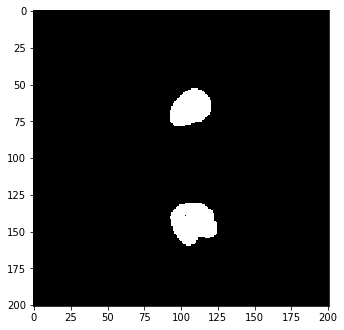

In [164]:
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.imshow(mask[:, :, 10], cmap="gray")


## Inference for SRM Segmentation

In [45]:
cropped_image_path = "/projects/renal/srm_detection_main/application/holdout/voi"
cropped_data = load_cropped_data(cropped_image_path)

Loading dataset: 100%|██████████| 11/11 [00:00<00:00, 1023.84it/s]


In [167]:
for i in range(11):
    voi_mask, voi = predict_cropped_srm(cropped_data['img'][i], cropped_data['Patient_ID'][i])

Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 876.55it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 2807.43it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 2998.07it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 10782.27it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 9799.78it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 3741.57it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 1845.27it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 12595.51it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 1582.16it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).



Loading dataset: 100%|██████████| 1/1 [00:00<00:00, 9962.72it/s]

BasicUNet features: (16, 32, 64, 128, 32, 16).


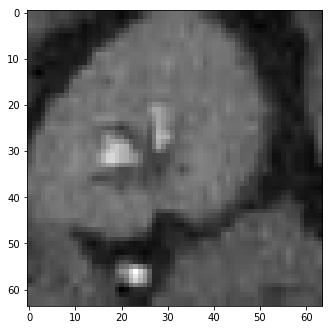

In [65]:
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.imshow(voi[:, :, 10], cmap="gray")

## Inference for Classification

### Monte Carlo Dropout: 

- We enabled dropout by setting best_cnn_model.train(), even during inference.

- Multiple Predictions: For each sample, the model runs n_samples times to generate multiple probabilities, which are then averaged to get the mean probability and standard deviation.

- Standard Deviation: The standard deviation of the probabilities is calculated to represent the model's uncertainty for each sample.
This approach gives us both the predicted class and its associated confidence level (mean probability and standard deviation).

In [212]:
model_cc='/projects/renal/srm_detection_main/models/weights/classification/ccRCC_vs_non_ccRCC/best_ccRCC_vs_non_ccRCC_clf_fold_5.pth' 
output_path_cc="/projects/renal/demo_predictions/classification/ccRCC_vs_NonccRCC.csv"

model_grade='/projects/renal/srm_detection_main/models/weights/classification/grade/best_grade_clf_fold_5.pth' 
output_path_grade="/projects/renal/demo_predictions/classification/high_vs_low_grade.csv"

model_subtype='/projects/renal/srm_detection_main/models/weights/classification/subtype/best_subtype_clf_fold_5.pth' 
output_path_subtype="/projects/renal/demo_predictions/classification/ccRCC_vs_papRCC.csv"

predict_srm(cropped_data, model_cc, output_path_cc, keys=("Non ccRCC", "ccRCC"))
predict_srm(cropped_data, model_grade, output_path_grade, keys=("Low", "High"))
predict_srm(cropped_data, model_subtype, output_path_subtype, keys=("papRCC", "ccRCC"))


Loading dataset: 100%|██████████| 11/11 [00:00<00:00, 1618.57it/s]


,Patient_ID,Prediction,Probability,Std_Prob
0,Renal-CHUS-0062,ccRCC,0.999018,0.002906
1,Renal-CHUS-0050,papRCC,0.806733,0.125563
2,Renal-CHUS-0073,ccRCC,0.999874,0.000534
3,Renal-CHUS-0105,ccRCC,0.999997,0.000012
4,Renal-CHUS-0107,ccRCC,0.999988,0.000042
5,Renal-CHUS-0061,ccRCC,0.999940,0.000358
6,Renal-CHUS-0106,ccRCC,0.971639,0.050814
7,Renal-CHUS-0048,ccRCC,0.999708,0.000468
8,Renal-CHUS-0069,papRCC,0.560147,0.045017
9,Renal-CHUS-0068,ccRCC,0.946213,0.094350
